In [ ]:
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import random
random.seed(42)
np.random.seed(42)
print("Inisialisasi environment selesai.")

In [12]:
# CELL 1: SETUP & KONFIGURASI
# KELAS PEREDAM (untuk mengurangi spam log dari TF/CUDA)
class SuppressStderr:
    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for _ in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


Inisialisasi environment selesai.


In [ ]:
# CELL 2: LOAD DATASET & TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

with SuppressStderr():
    import tensorflow as tf
    tf.random.set_seed(42)  # seed untuk TensorFlow

print("Memuat dataset AG News...")

train_df = pd.read_csv("../dataset/train.csv")
test_df = pd.read_csv("../dataset/test.csv")

train_df.columns = ["Class Index", "Title", "Description"]
test_df.columns = ["Class Index", "Title", "Description"]

# Gabungkan Title + Description → text
train_df["text"] = train_df["Title"] + " " + train_df["Description"]
test_df["text"] = test_df["Title"] + " " + test_df["Description"]

# Sampling agar training tidak terlalu berat
train_df = train_df.sample(25000, random_state=42)
test_df = test_df.sample(2000, random_state=42)

X_train_raw = train_df["text"].values
y_train_raw = train_df["Class Index"].values - 1  # kelas: 0..3
X_test_raw = test_df["text"].values
y_test_raw = test_df["Class Index"].values - 1

# TF-IDF dengan n-gram (1,2)
vectorizer = TfidfVectorizer(
    max_features=4000,
    stop_words="english",
    ngram_range=(1, 2)
)

X_train_vec = vectorizer.fit_transform(X_train_raw).toarray()
X_test_vec = vectorizer.transform(X_test_raw).toarray()

print("TF-IDF selesai.")
print("Shape X_train_vec:", X_train_vec.shape)
print("Shape X_test_vec :", X_test_vec.shape)


Memuat dataset AG News...
TF-IDF selesai.
Shape X_train_vec: (25000, 4000)
Shape X_test_vec : (2000, 4000)


In [14]:
# CELL 3: FUNGSI PREPROCESSING (1–4)

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE

def cek_missing_value(X, name="X"):
    total_nan = np.isnan(X).sum()
    print(f"[1] Cek Missing Value - {name}: Total NaN = {total_nan}")
    return X

def fitur_transformasi_scaler(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    print("[2] MinMaxScaler - selesai.")
    print("    X_train_sc range: [", X_train_sc.min(), ",", X_train_sc.max(), "]")
    return X_train_sc, X_test_sc

def fitur_seleksi_chisquare(X_train, y_train, X_test, k=1500):
    selector = SelectKBest(score_func=chi2, k=k)
    X_train_fs = selector.fit_transform(X_train, y_train)
    X_test_fs = selector.transform(X_test)
    print(f"[3] Chi-square - selesai. Jumlah fitur terpilih: {k}")
    print("    Shape X_train_fs:", X_train_fs.shape)
    print("    Shape X_test_fs :", X_test_fs.shape)
    return X_train_fs, X_test_fs

def handle_imbalanced_smote(X_train, y_train, random_state=42):
    sm = SMOTE(random_state=random_state)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    unique_cls, counts = np.unique(y_res, return_counts=True)
    print("[4] SMOTE - selesai.")
    print("    Distribusi kelas setelah SMOTE:", dict(zip(unique_cls, counts)))
    print("    Shape X_res:", X_res.shape)
    return X_res, y_res


In [ ]:
# CELL 4: FUNGSI MODEL LSTM & EVALUASI
def build_vanilla_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [ ]:
def evaluasi_hasil(model, X_test, y_test_labels, train_time):
    start_test = time.time()
    y_prob = model.predict(X_test, verbose=0)
    test_time = time.time() - start_test

    y_pred = np.argmax(y_prob, axis=1)

    acc = accuracy_score(y_test_labels, y_pred)
    prec = precision_score(y_test_labels, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test_labels, y_pred, average="weighted", zero_division=0)
    auc = roc_auc_score(
        to_categorical(y_test_labels, 4),
        y_prob,
        multi_class="ovr"
    )

    hasil = {
        "Akurasi": acc,
        "Presisi": prec,
        "Recall": rec,
        "AUC/ROC": auc,
        "Waktu Training (s)": train_time,
        "Waktu Testing (s)": test_time
    }

    print("\n=== HASIL EVALUASI MODEL (Vanilla LSTM + SMOTE) ===")
    print(f"Akurasi : {hasil['Akurasi']:.4f}")
    print(f"Presisi : {hasil['Presisi']:.4f}")
    print(f"Recall  : {hasil['Recall']:.4f}")
    print(f"AUC/ROC : {hasil['AUC/ROC']:.4f}")
    print(f"Waktu Training (s): {hasil['Waktu Training (s)']:.2f}")
    print(f"Waktu Testing  (s): {hasil['Waktu Testing (s)']:.4f}")

    return hasil

In [16]:
# CELL 5: EKSEKUSI PIPELINE LENGKAP

final_results = {}

print("\n======================================")
print(" PIPELINE: TF-IDF → PREPROCESSING → LSTM ")
print("========================================")

# 1. Cek Missing Value
X1_train = cek_missing_value(X_train_vec, name="X_train_vec")
X1_test  = cek_missing_value(X_test_vec,  name="X_test_vec")

# 2. Transformasi --> MinMaxScaler
X1_train_sc, X1_test_sc = fitur_transformasi_scaler(X1_train, X1_test)

# 3. Seleksi Fitur (Chi-square)
X1_train_fs, X1_test_fs = fitur_seleksi_chisquare(
    X1_train_sc,
    y_train_raw,
    X1_test_sc,
    k=1500
)

# 4. Imbalanced Data (SMOTE)
X1_train_sm, y1_train_sm = handle_imbalanced_smote(
    X1_train_fs,
    y_train_raw,
    random_state=42
)

# Siapkan data untuk LSTM
y1_train_cat = to_categorical(y1_train_sm, 4)
X1_train_lstm = X1_train_sm.reshape((X1_train_sm.shape[0], 1, X1_train_sm.shape[1]))
X1_test_lstm  = X1_test_fs.reshape((X1_test_fs.shape[0], 1, X1_test_fs.shape[1]))

print("\n[Info] Shape untuk LSTM:")
print("      X1_train_lstm:", X1_train_lstm.shape)
print("      X1_test_lstm :", X1_test_lstm.shape)

# 5. Metode LSTM (Training)
print("\n[5] Training Vanilla LSTM + SMOTE...")
with SuppressStderr():
    model_lstm = build_vanilla_lstm_model((1, X1_train_lstm.shape[2]))

    es = EarlyStopping(
        monitor="accuracy",
        patience=5,
        restore_best_weights=True
    )

    start_train = time.time()
    history = model_lstm.fit(
        X1_train_lstm,
        y1_train_cat,
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=1
    )
    train_time = time.time() - start_train

# Evaluasi
hasil_lstm = evaluasi_hasil(
    model_lstm,
    X1_test_lstm,
    y_test_raw,
    train_time
)

final_results["Proses 2 (Vanilla LSTM + SMOTE)"] = hasil_lstm

print("\nRingkasan hasil:")
for nama, metrik in final_results.items():
    print(f"\n>>> {nama}")
    print(f"    Akurasi : {metrik['Akurasi']:.4f}")
    print(f"    Recall  : {metrik['Recall']:.4f}")
    print(f"    Presisi : {metrik['Presisi']:.4f}")
    print(f"    AUC/ROC : {metrik['AUC/ROC']:.4f}")



 PIPELINE: TF-IDF → PREPROCESSING → LSTM 
[1] Cek Missing Value - X_train_vec: Total NaN = 0
[1] Cek Missing Value - X_test_vec: Total NaN = 0
[2] MinMaxScaler - selesai.
    X_train_sc range: [ 0.0 , 1.0 ]
[3] Chi-square - selesai. Jumlah fitur terpilih: 1500
    Shape X_train_fs: (25000, 1500)
    Shape X_test_fs : (2000, 1500)
[4] SMOTE - selesai.
    Distribusi kelas setelah SMOTE: {0: 6329, 1: 6329, 2: 6329, 3: 6329}
    Shape X_res: (25316, 1500)

[Info] Shape untuk LSTM:
      X1_train_lstm: (25316, 1, 1500)
      X1_test_lstm : (2000, 1, 1500)

[5] Training Vanilla LSTM + SMOTE...
Epoch 1/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7170 - loss: 0.7698
Epoch 2/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8891 - loss: 0.3342
Epoch 3/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8953 - loss: 0.3049
Epoch 4/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8984 - loss: 0.2860
Epoch 5/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accur

KeyError: 'val_accuracy'

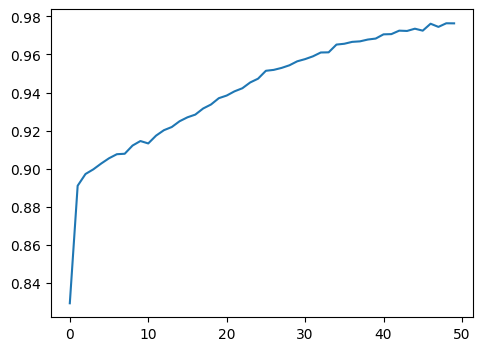

In [17]:
# # CELL 6: VISUALISASI TRAINING vs VALIDATION (AKURASI & LOSS)

# plt.figure(figsize=(12, 4))

# # --- Plot Akurasi ---
# plt.subplot(1, 2, 1)
# plt.plot(history.history["accuracy"], label="Train Accuracy")
# plt.plot(history.history["val_accuracy"], label="Val Accuracy")
# plt.title("Training vs Validation Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)

# # --- Plot Loss ---
# plt.subplot(1, 2, 2)
# plt.plot(history.history["loss"], label="Train Loss")
# plt.plot(history.history["val_loss"], label="Val Loss")
# plt.title("Training vs Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()


In [ ]:
# CELL 7: CORRELATION MAP (CONFUSION MATRIX HEATMAP)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prediksi pada data test
y_prob = model_lstm.predict(X1_test_lstm, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_test_raw, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"Pred {i}" for i in range(4)],
    yticklabels=[f"True {i}" for i in range(4)]
)
plt.title("Confusion Matrix (Correlation Map: True vs Predicted Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
